In [1]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
)
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
devNumber = torch.cuda.current_device()
devName = torch.cuda.get_device_name(devNumber)

print(f"Using device: {device}")
print(f"Current device number is: {devNumber}")
print(f"GPU name is: {devName}")

Using device: cuda
Current device number is: 0
GPU name is: NVIDIA GeForce GTX 1650


Using device: cuda
Epoch [1/20], Loss: 1.5915, Accuracy: 0.5379
Epoch [2/20], Loss: 1.1358, Accuracy: 0.6521
Epoch [3/20], Loss: 0.9099, Accuracy: 0.7050
Epoch [4/20], Loss: 0.7793, Accuracy: 0.7210
Epoch [5/20], Loss: 0.6889, Accuracy: 0.7402
Epoch [6/20], Loss: 0.6138, Accuracy: 0.7360
Epoch [7/20], Loss: 0.5583, Accuracy: 0.7556
Epoch [8/20], Loss: 0.5051, Accuracy: 0.7551
Epoch [9/20], Loss: 0.4575, Accuracy: 0.7490
Epoch [10/20], Loss: 0.4233, Accuracy: 0.7583
Epoch [11/20], Loss: 0.3928, Accuracy: 0.7517
Epoch [12/20], Loss: 0.3598, Accuracy: 0.7630
Epoch [13/20], Loss: 0.3474, Accuracy: 0.7655
Epoch [14/20], Loss: 0.3234, Accuracy: 0.7630
Epoch [15/20], Loss: 0.3129, Accuracy: 0.7505
Epoch [16/20], Loss: 0.2913, Accuracy: 0.7641
Epoch [17/20], Loss: 0.2999, Accuracy: 0.7547
Epoch [18/20], Loss: 0.2865, Accuracy: 0.7556
Epoch [19/20], Loss: 0.2814, Accuracy: 0.7588
Epoch [20/20], Loss: 0.2650, Accuracy: 0.7558

Final Test Accuracy: 0.7558
Precision: 0.7595
Recall: 0.7558
F1 Score

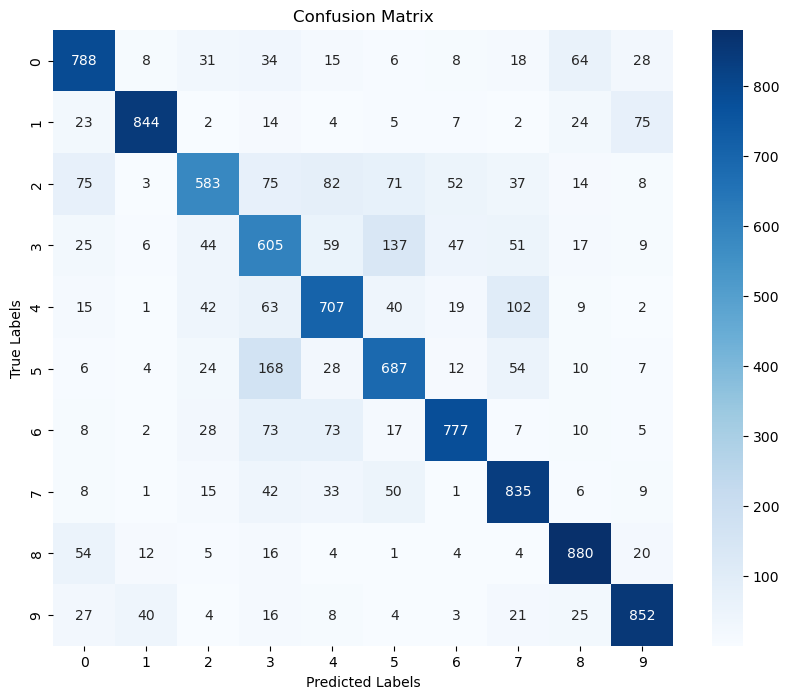

In [ ]:
# Problem 1: Simplified Alexnet model CIFAR-10
# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 20
num_classes = 10

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize(32),  # Resize to match CIFAR-10 (already 32x32)
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the AlexNet model (modified for CIFAR-10)
class AlexNetCIFAR10(nn.Module):
    def __init__(self, num_classes):
        super(AlexNetCIFAR10, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  # Changed kernel size
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 32x32 -> 16x16
            
            nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 16x16 -> 8x8
            
            nn.Conv2d(192, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 8x8 -> 4x4
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 4096),  # Adjusted for CIFAR-10 image size
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)  # Output layer for CIFAR-10
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Initialize model, loss function, and optimizer
model = AlexNetCIFAR10(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training function
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Evaluate on test data
        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_accuracy = accuracy_score(all_labels, all_preds)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, Accuracy: {val_accuracy:.4f}")

# Train the model
train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs)

print(f"\nTraining Time: {training_time:.2f} seconds")


# Plot Training Loss and Accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(range(len(train_losses)), train_losses, label="Training Loss", color="blue")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Training Loss")
ax1.legend()

ax2.plot(range(len(train_accuracies)), train_accuracies, label="Training Accuracy", color="blue")
ax2.plot(range(len(val_accuracies)), val_accuracies, label="Validation Accuracy", color="red")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.set_title("Training vs. Validation Accuracy")
ax2.legend()

plt.show()

# Final evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute final metrics
final_accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="macro")

print(f"\nFinal Test Accuracy: {final_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()